In [3]:
library(GenSA)
library(ggplot2)
library(GA)
library(magrittr)
library(quantmod)
library(PerformanceAnalytics)
library(knitr)

#### Portfolio Optimization

Reference: https://cran.r-project.org/web/packages/PortfolioAnalytics/vignettes/portfolio_vignette.pdf

Mean-risk models were developed in the 1950s for portfolio selection problems. Value-at-Risk (VaR) and Conditional Value-at-Risk (CVaR) are the most popular measures of downside risk. Mullen et al. (2011) and Ardia et al. (2011) used DEoptim to find the portfolio weights for which the portfolio has the lowest CVaR and each investment can contribute at most 22.5% to total portfolio CVaR risk. For details, please refer to Mullen et al. (2011); Ardia et al. (2011). The code for objective function in portfolio optimization are from Ardia et al. (2011) (https://journal.r-project.org/archive/2011/RJ-2011-005/RJ-2011-005.pdf)

### 1. Apply Genetic Algorithm to the Portfolio problem. How does the performance of the GA compare to simulated annealing?

In [19]:
tickers <- c("GE", "IBM", "GOOG", "AMZN", "AAPL")
getSymbols(tickers, from = "2012-10-01", to = "2018-10-31")
P <- NULL

for(ticker in tickers) {
 tmp <- Cl(to.monthly(eval(parse(text = ticker))))
 P <- cbind(P, tmp)
}

colnames(P) <- tickers

R <- diff(log(P))
R <- R[-1,]
mu <- colMeans(R)
sigma <- cov(R)

pContribCVaR <- ES(
    weights = rep(0.2, 5),
    method = "gaussian",
    portfolio_method = "component",
    mu = mu,
    sigma = sigma) %>%
    extract("pct_contrib_ES")

pb_obj <- function(w) {

 if (sum(w) == 0) { w <- w + 1e-2 }
 w <- w / sum(w)
    
 CVaR <- ES(
     weights = w,
     method = "gaussian",
     portfolio_method = "component",
     mu = mu,
     sigma = sigma
 )
    
 tmp1 <- CVaR$ES
 tmp2 <- max(CVaR$pct_contrib_ES - 0.225, 0)
 out <- tmp1 + 1e3 * tmp2
    
 return(out)
}

[1] "GE"   "IBM"  "GOOG" "AMZN" "AAPL"

In [20]:
stock_percentage <- function(weight_vals) {
    return(weight_vals %>%
        divide_by(sum(weight_vals)) %>%
        multiply_by(100) %>%
        round(2)
    )
}

### A simulated anealing approach to the portfolio problem

In [7]:
set.seed(1234)

sa_prob <- GenSA(
    fn = pb_obj,
    lower = rep(0, 5),
    upper = rep(1, 5),
    control = list(
        smooth = FALSE,
        max.call = 3000
    )
)

In [8]:
sa_prob %>% extract("value")

$value
[1] 0.07775638

In [9]:
sa_prob %>% extract("par")

$par
[1] 0.8751464 0.8006182 0.9954303 0.3149181 0.8634851

In [10]:
sa_prob %>% extract("counts")

$counts
[1] 3000

In [25]:
rbind(tickers, stock_percentage(sa_prob$par))

tickers,GE,IBM,GOOG,AMZN,AAPL
,22.73,20.8,25.86,8.18,22.43


### A Genetic Algorithm approach to the portfolio problem

── Genetic Algorithm ─────────────────── 

GA settings: 
Type                  =  real-valued 
Population size       =  50 
Number of generations =  100 
Elitism               =  2 
Crossover probability =  0.8 
Mutation probability  =  0.1 
Search domain = 
      x1 x2 x3 x4 x5
lower  0  0  0  0  0
upper  1  1  1  1  1

GA results: 
Iterations             = 100 
Fitness function value = -0.07794978 
Solution = 
            x1        x2        x3       x4        x5
[1,] 0.7134268 0.6356015 0.7976107 0.287926 0.7030801

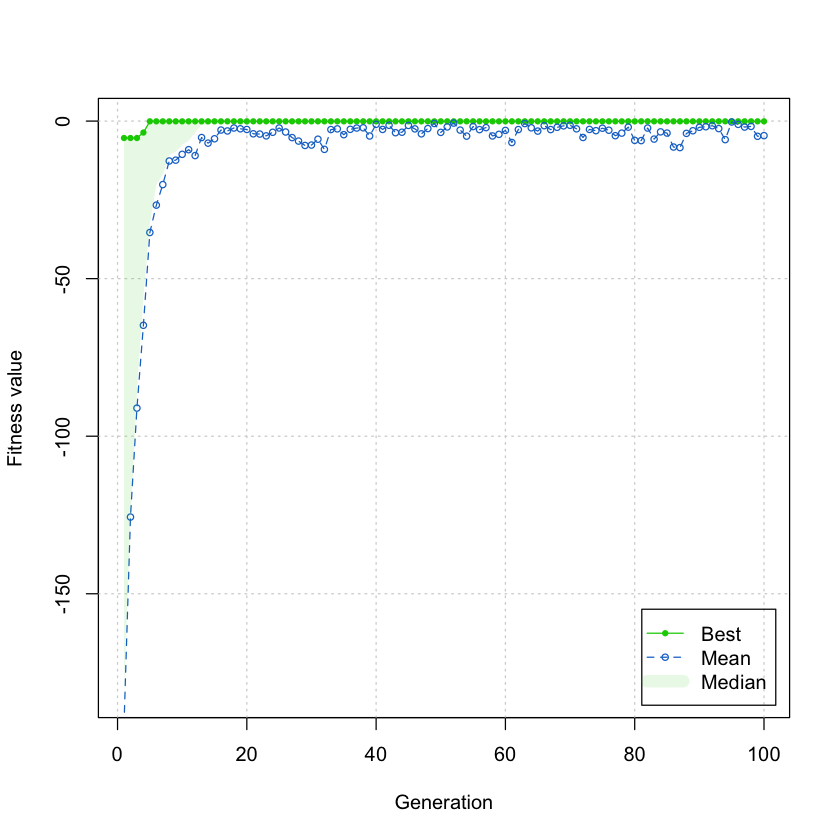

In [12]:
ga_prob <- ga(
    type = "real-valued",
    fitness = function(w) -pb_obj(w), 
    lower = rep(0,5),
    upper = rep(1,5),
    popSize = 50
)
summary(ga_prob)
plot(ga_prob)

In [24]:
rbind(tickers, stock_percentage(ga_prob@solution))

,x1,x2,x3,x4,x5
tickers,GE,IBM,GOOG,AMZN,AAPL
,22.74,20.26,25.42,9.18,22.41


Let's compare the value of the weights obtained using `GA` and `GenSA`

In [14]:
ga_solutions <- c(ga_prob@solution, ga_prob@fitnessValue)
sa_soultions <- c(sa_prob$par, sa_prob$value)

p <- matrix(
    c(ga_solutions, sa_soultions),
    ncol = 2
)

rownames(p) <- c( "GE", "IBM", "GOOG", "AMZN", "AAPL", "Fitness Value")
colnames(p) <- c("Genetic Algorithm", "Simulated Annealing")

as.table(p) %>% kable(caption = "")



|              | Genetic Algorithm| Simulated Annealing|
|:-------------|-----------------:|-------------------:|
|GE            |         0.7134268|           0.8751464|
|IBM           |         0.6356015|           0.8006182|
|GOOG          |         0.7976107|           0.9954303|
|AMZN          |         0.2879260|           0.3149181|
|AAPL          |         0.7030801|           0.8634851|
|Fitness Value |        -0.0779498|           0.0777564|

Let's compare the results of how much should we invest into our stocks obtained using `GA` and `GenSA`

In [23]:
ga_percentages <- c(stock_percentage(ga_prob@solution))
sa_percentages <- c(stock_percentage(sa_prob$par))

p <- matrix(
    c(ga_percentages, sa_percentages),
    ncol = 2
)

rownames(p) <- c( "GE", "IBM", "GOOG", "AMZN", "AAPL")
colnames(p) <- c("Genetic Algorithm", "Simulated Annealing")

as.table(p) %>% kable(caption = "")



|     | Genetic Algorithm| Simulated Annealing|
|:----|-----------------:|-------------------:|
|GE   |             22.74|               22.73|
|IBM  |             20.26|               20.80|
|GOOG |             25.42|               25.86|
|AMZN |              9.18|                8.18|
|AAPL |             22.41|               22.43|

### 2. Use GA and SA to search for optimal b0 and b1 estimates. The objective should be to minimize  SSE (sums of square error). How does this compare to the exhaustive search you did in your class?

In [ ]:
x <- c(61, 63, 67, 69, 70, 74, 76, 81, 86, 91, 95, 97)
y <- c(4.28, 4.08, 4.42, 4.17, 4.48, 4.3, 4.82, 4.7, 5.11, 5.13, 5.64, 5.56)

In [ ]:
ssyy <- sum((y - mean(y)) ^ 2)
ssxy <- sum((x - mean(x)) * (y - mean(y)))
ssx <- sum((x - mean(x)) ^ 2)
b1 <- ssxy/ssx
b0 <- mean(y) - b1 * mean(x)

print(b1)
print(b0)

In [ ]:
linear_model <- lm(y ~ x)

summary(linear_model)

In [ ]:
obj <- function (r) {
    fn <- function (b0, b1) {
        return (sum(y - (b0 + b1 * x)) ^ 2)
    }
    return (fn(r[1], r[2]))
}

ubound <- c(2, 1)
lbound <- c(0, 0)

## Genetic Algorithm

In [ ]:
ga_search <- ga(
    type = "real-valued",
    fitness = function (x) -obj(x),
    lower = lbound,
    upper = ubound,
    popSize = 50
)

summary(ga_search)
plot(ga_search)

## Simulated Anealing 

In [ ]:
par <- c(1, 0)

sa_search <- GenSA(
    par = par,
    lower = lbound,
    upper = ubound,
    fn = obj
)

In [ ]:
sa_search %>% extract("value")

In [ ]:
sa_search %>% extract("par")

In [ ]:
sa_search %>% extract("counts")

### 3. Plot your solution, and the optimal regression line (using the built-in function). Clearly label the output.

In [ ]:
dataset = data.frame(x, y)
plot(x, y, col = "red", xlab = "X", ylab = "Y")

abline(c(ga_search@solution), col = "red")
abline(c(sa_search$par), col = "blue")